##### Import the data 

In [1]:
%%time 
import pandas as pd 
import sqlite3
import operator
# conn_sql = sqlite3.connect("../data/pubcrawler-04-19-2021.db")
conn = sqlite3.connect("../data/pub_raw.db")

journals = pd.read_sql_query("SELECT * FROM journal",conn)
authors = pd.read_sql_query("SELECT * FROM author",conn)
paper = pd.read_sql_query("SELECT * FROM paper", conn)
keyword = pd.read_sql_query("SELECT * FROM keyword", conn)
paper_authors = pd.read_sql_query("SELECT * FROM paper_author", conn)
paper_keyword = pd.read_sql_query("SELECT * FROM paper_keyword", conn)
subject = pd.read_sql_query("SELECT * FROM subject", conn)
paper_subject= pd.read_sql_query("SELECT * FROM paper_subject", conn)

Wall time: 759 ms


# Creating the network with networkx 

- create author nodes with their attributes 
- create edges between authors who have co-authored a paper together
- the edge weight represents the amount of times that pair of authors have co-authored a paper 

## Creating nodes

In [2]:
%%time

import networkx as nx 
import matplotlib.pyplot as plt 
G = nx.Graph()
# G.add_nodes_from(author_nodes)
# G.add_edges_from(all_edges_lists)

def create_author_nodes():
    authors_array = authors.values
    for row in authors_array:
        G.add_nodes_from([row[0]],
                         first_name = row[2],
                         last_name= row[3],
                        middle_name = row[4],
                        email = row[5])
create_author_nodes() 


first_name = nx.get_node_attributes(G,'first_name')
last_name = nx.get_node_attributes(G,'last_name')
middle_name = nx.get_node_attributes(G,'middle_name')
email = nx.get_node_attributes(G,'email')
G.number_of_nodes()       

Wall time: 815 ms


6366

## Creating Edges

In [3]:
%%time

distinct_papers = pd.read_sql_query("SELECT distinct paper_id FROM paper_author" , conn)

# grouping together the authors that worked on a single paper together 

def create_author_groups():
    # initilize an author group list 
    all_author_groups = []
    for i in range(1,len(distinct_papers) + 1):
        # group the authors who worked on a paper together 
        author_group = paper_authors.loc[(paper_authors['paper_id'] == i ),'author_id'].values
        all_author_groups.append(author_group)
        
    return all_author_groups


def reverse(tuples):
    new_tup = tuples[::-1]
    return new_tup


def author_combinations():
    from itertools import combinations
    all_edges_new = []
    all_edges = []
    for group in all_author_groups:
        comb = combinations(group,2)
        for pair in list(comb):
            all_edges.append(pair)
    
    # giving all edge pairs the same order: (2,1) and (1,2) would both equal (2,1)
    for edge in all_edges:
        if edge not in all_edges_new and reverse(edge) not in all_edges_new:
            all_edges_new.append(edge)
    
        elif edge in all_edges_new:
            all_edges_new.append(edge)
    
        elif reverse(edge) in all_edges_new:
            all_edges_new.append(reverse(edge))       
            
    return all_edges_new



def assign_weights():
    single_edges = []  # all edges that would have a weight of ONLY 1 
    multiple_edges_dict = {} 
    for edge in author_relationships:
        if edge in single_edges:
            multiple_edges_dict[edge] = multiple_edges_dict.get(edge,1) + 1         
        else:
            single_edges.append(edge)

    keys = multiple_edges_dict.keys()

    for key in keys:
        if key in single_edges in single_edges:
            single_edges.remove(key)
            
            
    single_edges_dict = {}
    for edge in single_edges:
        single_edges_dict[edge] = 1
        
        
    all_edges_dict = {}
    all_edges_dict.update(single_edges_dict)
    all_edges_dict.update(multiple_edges_dict)    
    return all_edges_dict



def add_edges():
    weights = [i for i in author_relationship_weights.values()]
    keys = author_relationship_weights.keys()
    keys_list = [key for key in keys]
    count = 0 
    unadded_edges = []
    for relationship in author_relationship_weights.keys():
        G.add_edge(relationship[0], relationship[1], weight= weights[count])
        count += 1 


all_author_groups = create_author_groups()
author_relationships = author_combinations()
# author_relationships_lists = [list(edge) for edge in author_relationships] 
author_relationship_weights = assign_weights()
add_edges()


Wall time: 5.71 s


In [4]:
print(len(author_relationship_weights) == G.number_of_edges())
print(len(author_relationships) == sum(author_relationship_weights.values()))

True
True


### Adding authors degrees table to the database 

In [5]:
# top_10_degrees = sorted(dict(G.degree()).items(), key=operator.itemgetter(1), reverse=True)[0:10]
author_degrees = pd.DataFrame(sorted(dict(G.degree()).items(), key=operator.itemgetter(1), reverse=True),columns= ['author_id', 'num_degrees'])
author_degrees.to_sql('author_degrees', conn, if_exists='replace', index=False)
author_degrees = pd.read_sql('select * from author_degrees', conn)
author_degrees.head()

,author_id,num_degrees
0,656,53
1,51,52
2,95,49
3,58,45
4,433,40


##### Degree Centrality 

In [6]:
# adding degree centrality as a node attribute 

degree_centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, degree_centrality, "degree")
degree = nx.get_node_attributes(G,'degree')

##### Closeness Centrality 

In [7]:
%%time 

# adding closeness centality as a node attribute 

closeness_centrality = nx.closeness_centrality(G)
nx.set_node_attributes(G, degree_centrality, "closseness centrality" )
closeness = nx.get_node_attributes(G,'closseness centrality')

Wall time: 16.9 s


In [8]:
print(f'Average clustering coeffiecent:{nx.average_clustering(G)}')

# transitivity weighs nodes with lower degrees lower 
print(f'Transitivity:{nx.transitivity(G)}')

Average clustering coeffiecent:0.6002537468702823
Transitivity:0.394731518734126


# Queries

##### Which nodes(authors) have the most degrees

In [9]:
degrees  = pd.read_sql_query("""
select author_degrees.author_id,author.full_name, author_degrees.num_degrees
from author_degrees inner join author 
on author_degrees.author_id = author.id
""",conn)
degrees 

,author_id,full_name,num_degrees
0,656,"Agarwal, Ritu",53
1,51,"Rai, Arun",52
2,95,"Dennis, Alan R.",49
3,58,"Venkatesh, Viswanath",45
4,433,"Pavlou, Paul A.",40
...,...,...,...
6361,6362,"Lockman, Abe",0
6362,6363,"Shalev, Jacob",0
6363,6364,"Clark, Steven J.",0
6364,6365,"Norman, Morton",0


##### Which authors have published the most papers?

In [11]:
# most papers by author

pd.read_sql_query("""select author.id, author.full_name, count(paper_author.paper_id) as num_papers
from author inner join paper_author
on author.id = paper_author.author_id
group by author.id
order by num_papers desc """,conn)

,id,full_name,num_papers
0,4241,"Zwass, Vladimir",118
1,2241,"Clemons, Eric K.",46
2,656,"Agarwal, Ritu",39
3,51,"Rai, Arun",39
4,1611,"Ives, Blake",36
...,...,...,...
6361,9,"Malgonde, Onkar",1
6362,8,"Hærem, Thorvald",1
6363,7,"Kremser, Waldemar",1
6364,6,Peng Liu,1


##### Which journal published the most papers?

In [12]:
# most papers by journal 
all_papers = len(paper)

papers_per_journal = pd.read_sql_query("""
select journal.journal_title, count(paper.id) as num_papers_published
from journal inner join paper
on journal.id = paper.journal_id
group by journal_title
order by num_papers_published desc

""",conn)
papers_per_journal['percentage'] = papers_per_journal['num_papers_published']/all_papers
papers_per_journal.head()

,journal_title,num_papers_published,percentage
0,MIS Quarterly,1969,0.435042
1,Journal of Management Information Systems,1476,0.326116
2,Information Systems Research,1081,0.238842


##### Which journal has the most issues?

In [13]:
issues_per_journal = pd.read_sql_query("""
select journal.journal_title, count(journal.issue) as num_issues
from journal
group by journal.journal_title
order by num_issues desc

""",conn)

issues_per_journal.head()

,journal_title,num_issues
0,MIS Quarterly,174
1,Journal of Management Information Systems,145
2,Information Systems Research,120


##### Which subjects are most written about?

In [15]:
most_subjects = pd.read_sql_query("""
select  subject.subject, count(subject.subject) as num
from subject inner join paper_subject
on subject.id = paper_subject.subject_id inner join paper
on paper_subject.paper_id = paper.id
group by subject.subject
order by num desc

""",conn)
most_subjects


,subject,num
0,information technology,1075
1,information resources management,1064
2,management information systems,814
3,information storage & retrieval systems,433
4,information resources,387
...,...,...
4749,abusive behavior,1
4750,abstracting & indexing services,1
4751,abstracting,1
4752,ability testing,1


# Community detection 

In [16]:
%%time

from networkx.algorithms import community

communities_generator = community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)


Wall time: 47min 7s


[[1,
  2,
  3,
  4,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  42,
  43,
  44,
  49,
  50,
  51,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  131,
  132,
  149,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  163,
  164,
  167,
  168,
  169,
  173,
  174,
  175,
  176,
  177,
  178,
  179,
  183,
  184,
  185,
  186,
  187,
  188,
  189,
  195,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
  203,
  204,
  205,
  206,
  207,
  208,
  211,
  212,
  213,
  214,
  215,
  216,
  219,
  220,
  226,
  227,
  228,
  229,
  230,
  231,
  232,
  233,
  234,
  235,
  236,
  237,
  238,
  239,
  240,
  241,
  242,
  243,
  248,


In [67]:
# next_level_communities = sorted(map(sorted, next_level_communities))
next_level_communities.sort(key= len, reverse = True)
len(next_level_communities[3])

111

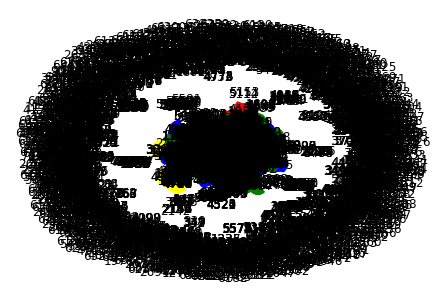

In [68]:
color_map = []
for node in G:
    if node in next_level_communities[0]:
        color_map.append('blue')
    elif node in next_level_communities[1]: 
        color_map.append('green')
    elif node in next_level_communities[2]:
        color_map.append('red')
    elif node in next_level_communities[3]:
        color_map.append('yellow')
    else:
        color_map.append('white')
nx.draw(G, node_color=color_map, with_labels=True)
plt.show()

##### Write the edges file 
- import to SQL 

In [ ]:
# # creates a file with all the author relationships 

# relationships = author_relationship_weights.keys()
# edge_id = [i+1 for i in range(len(relationships))]
# weights =  author_relationship_weights.values()

# # edges = pd.DataFrame([edge_id, relationships, weights],columns=['edge_id', 'author1', 'author2', 'weight'])
# edges = pd.DataFrame(relationships,columns=['author1', 'author2'])
# edges['edge_id'] = edge_id
# edges['weight'] = weights 



# edges = edges[['edge_id', 'author1', 'author2', 'weight']]
# edges
# edges.to_csv('edges.csv',index=False)